In [1]:
import os
from dataset_utils import *

train_path = os.path.join(IMDB_DATA_PATH, "train")
test_path  = os.path.join(IMDB_DATA_PATH, "test")

"""
For details on implementation of dataset loading and other utils check out dataset_utils.py

CONVENTION: label 0 --> negative review
            label 1 --> positive review
"""

#Main training set - Large Movie Review Dataset (IMDB)
((imdb_train_texts, imdb_train_labels), (imdb_test_texts, imdb_test_labels)) = load_imdb_dataset(train_path=train_path, test_path=test_path)

#Review Polarity Datasets
(v1_texts, v1_labels), (v2_texts, v2_labels) = load_polarity(v1_path=POLARITY_v1_DATA_PATH, v2_path=POLARITY_v2_DATA_PATH)

#Rotten tomatoes critic dataset
rotten_train_texts, rotten_train_labels, short_rotten_train, short_rotten_test, random_rotten_test, pos_rotten_test, neg_rotten_test = load_rotten_split(ROTTEN_PATH, n_train_samples=4000)

In [2]:
from sklearn.model_selection import train_test_split

short_rotten_train_texts = [text for _, text in short_rotten_train]
short_rotten_train_labels = [label for label, _ in short_rotten_train]

train_texts_v1, test_texts_v1, train_labels_v1, test_labels_v1 = train_test_split(v1_texts, v1_labels, test_size=0.33, random_state=42)
train_texts_v2, test_texts_v2, train_labels_v2, test_labels_v2 = train_test_split(v2_texts, v2_labels, test_size=0.33, random_state=42)
 
train_texts = imdb_train_texts + rotten_train_texts + train_texts_v1 + train_texts_v2
train_labels = imdb_train_labels + rotten_train_labels + train_labels_v1 + train_labels_v2


seed=10
random.seed(seed)
random.shuffle(train_texts)
random.seed(seed)
random.shuffle(train_labels)

print(f"Training set size: {len(train_texts)}")

Training set size: 37483


In [3]:
from sklearn.feature_extraction.text import CountVectorizer

MAX_FEATURES = 100000
TARGET_LENGTH = 250

vectorizer = CountVectorizer(ngram_range=(1,1), lowercase=True, max_features=MAX_FEATURES)
vectorizer.fit(train_texts)

vocab = vectorizer.vocabulary_
remapped_vocab = {ngram: idx+1 for idx, (ngram, _) in enumerate(sorted(vocab.items(),key=lambda x: x[1]))}

remapped_vocab['<pad>'] = 0
remapped_vocab['<OOV>'] = len(remapped_vocab)

inverse_vocab = {idx: ngram for ngram, idx in remapped_vocab.items()}

analyzer = vectorizer.build_analyzer()
tokenizer = vectorizer.build_tokenizer()

In [4]:
import torch
from torch import nn
import torch.nn.functional as F

torch.manual_seed(0)

vocab_size = len(remapped_vocab)

class SentimentCNN(nn.Module):
    def __init__(self, embedding_dim, out_channels, kernel_size1, kernel_size2, kernel_size3):
        super().__init__()
        
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
        
        self.conv1 = nn.Conv1d(in_channels=embedding_dim, out_channels=out_channels, kernel_size=kernel_size1)
        self.conv2 = nn.Conv1d(in_channels=embedding_dim, out_channels=out_channels, kernel_size=kernel_size2)
        self.conv3 = nn.Conv1d(in_channels=embedding_dim, out_channels=out_channels, kernel_size=kernel_size3)
        
        self.conv_stack1 = nn.Sequential(
            nn.Conv1d(in_channels=embedding_dim, out_channels=out_channels, kernel_size=kernel_size1),
            nn.ReLU(),
            nn.Dropout1d(p=0.2)
        ) 
        
        self.conv_stack2 = nn.Sequential(
            nn.Conv1d(in_channels=embedding_dim, out_channels=out_channels, kernel_size=kernel_size2),
            nn.ReLU(),
            nn.Dropout1d(p=0.2)
        )
        
        self.conv_stack3 = nn.Sequential(
            nn.Conv1d(in_channels=embedding_dim, out_channels=out_channels, kernel_size=kernel_size3),
            nn.ReLU(),
            nn.Dropout1d(p=0.2)
        )
    
        self.linear_stack = nn.Sequential(
            nn.Linear(in_features=600, out_features=300),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Linear(in_features=300, out_features=100),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Linear(in_features=100, out_features=1),
        )

                
    def forward(self, x):
        
        embed = self.embedding(x)
        embed = embed.transpose(1,2)
        
        conv1 = self.conv_stack1(embed)
        conv2 = self.conv_stack2(embed)
        conv3 = self.conv_stack3(embed)
        
        pool1 = F.max_pool1d(conv1, kernel_size=conv1.shape[2]).squeeze(2)
        pool2 = F.max_pool1d(conv2, kernel_size=conv2.shape[2]).squeeze(2)
        pool3 = F.max_pool1d(conv3, kernel_size=conv3.shape[2]).squeeze(2)
        
        cat = torch.cat((pool1, pool2, pool3), dim=1)
        
        return self.linear_stack(cat)        

In [5]:
def vectorize_text(text, analyzer, vocab):
    analyzed_list = analyzer(text)

    unigrams = [t for t in analyzed_list if len(t.split()) == 1]
    bigrams = [t for t in analyzed_list if len(t.split()) == 2]
    
    bigram_indices = [vocab.get(bigram) for bigram in bigrams]
    unigram_indices = [vocab.get(unigram) for unigram in unigrams]
    
    filled = [0 if idx is None else idx for idx in unigram_indices]
    
    return torch.tensor(filled)


def vectorize_mono(text, tokenizer, vocab):
    tokenized = tokenizer(text)
    index_vector = [vocab.get(mono) for mono in tokenized]
    
    filled = [vocab.get('<OOV>') if idx is None else idx for idx in index_vector]
    return torch.tensor(filled)


def tensor_to_text(tensor, inverse_vocab):
    return [inverse_vocab.get(val.item()) for val in tensor]

In [6]:
vectorized_train = [vectorize_mono(text, tokenizer=tokenizer, vocab=remapped_vocab) for text in train_texts]

In [58]:
tokenizer

<function Pattern.findall(string, pos=0, endpos=9223372036854775807)>

In [7]:
def pad_sequences(tensor_list, target_length, padding_value=0):
    padded_tensors = []
    
    for tensor in tensor_list:
        pad_length = target_length - len(tensor)
        padded_tensor = F.pad(tensor, (0, pad_length), value=padding_value)
        
        padded_tensors.append(padded_tensor.to(dtype=torch.int64))
        
    return torch.stack(padded_tensors)

In [8]:
padded_train = pad_sequences(vectorized_train, target_length=TARGET_LENGTH)

In [9]:
# ex_batch = padded_train[:64]
# embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=150)
# e = embedding(ex_batch).transpose(1,2)

# conv1 = nn.Conv1d(in_channels=150, out_channels=80, kernel_size=12)
# c = conv1(e)
# c.shape

# p = F.max_pool1d(c, kernel_size=6)
# f =torch.flatten(p, start_dim=1, end_dim=2)

# c.shape
# drop = nn.Dropout1d(p=0.2)
# batch = nn.BatchNorm1d(80)

# d = drop(c)

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Using: {device}")

Using: cuda


In [11]:
y=torch.tensor(train_labels, dtype=torch.float32).unsqueeze(1)

In [12]:
padded_train.shape

torch.Size([37483, 250])

In [16]:
from skorch import NeuralNetClassifier
from skorch.callbacks import Checkpoint, LoadInitState, LRScheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau, LinearLR, StepLR, ExponentialLR

model_dirs = sorted(os.listdir('models'))

#top experiment directory
dir_idx = 3
topdir = model_dirs[dir_idx]

#experiments within chosen vectorizer settings directory
experiments = sorted(os.listdir(f'models/{topdir}'))

if len(experiments) == 0:
    curr_number = 1
else:
    curr_number = int(experiments[-1][-1])
    
next_number = curr_number + 1

dirname_curr=f'models/{topdir}/exp{curr_number}'
f_pickle_curr=f'exp{curr_number}.pkl'

dirname_next=f'models/{topdir}/exp{next_number}'
f_pickle_next=f'exp{next_number}.pkl'

#checkpoints for saving the model during training. cp_current corresponds to the last experiment.
#When we switch the callback to cp_next, this starts a new experiment

cp_current = Checkpoint(monitor='valid_loss_best', dirname=dirname_curr, f_pickle=f_pickle_curr)
cp_next    = Checkpoint(monitor='valid_loss_best', dirname=dirname_next, f_pickle=f_pickle_next)
load_state = LoadInitState(cp_current)

lr_scheduler = ('lr_scheduler', LRScheduler(policy=ReduceLROnPlateau, mode='min', factor=0.1, patience=5))
lr_sched_step = ('lr_scheduler', LRScheduler(policy=StepLR, step_size=10, gamma=0.05))
lr_sched_linear = ('lr_scheduler', LRScheduler(policy=LinearLR, start_factor=0.3, end_factor=1, total_iters=7))
#lr_sched_exp = ('lr_scheduler', LRScheduler(policy=ExponentialLR, g))

net = NeuralNetClassifier(
    module=SentimentCNN,
    module__kernel_size1=2,
    module__kernel_size2=4,
    module__kernel_size3=6,
    module__embedding_dim=150,
    module__out_channels=200,
    lr = 0.001,
    criterion=nn.BCEWithLogitsLoss,   
    device=device,
    max_epochs=15,
    optimizer=torch.optim.Adam,
    #optimizer__momentum=0.99,
    optimizer__weight_decay=0.0001,
    batch_size=32,
    iterator_train__shuffle=False,
    #callbacks = [cp_current, load_state],
    callbacks = [cp_next],
    #callbacks=[cp_current]
)

#net.fit(X=padded_train, y=y)

# Notes from training


- Much better learning going from embedding_dim=50 to embedding_dim=100. seems like the complexity of the word vectors is a plus.
- l2 regularization (optimizer weight decay) very helpful for avoiding overfitting
- slow to train on conv kernel size=4 compared to 8. maybe because most training data is long or capturing the context is more important?
- in pooling entire length, training unblocked after using 2 CNN layers instead of 3 (4, 8 kernel sizes for CNN)
- in pooling entire length, training blocked after changing out_channels to 150 from 100 (6, 10 kernel sizes for CNN)
- in general, if a model doesnt start learning, turning off l2 regu works sometimes.
- completely opposed to above, sometimes cranking up l2 regu makes model start learning
- as can be seen below, increasing target length was the best thing for performance
- On the rotten dataset: when I don't give the model as many training samples from the rotten dataset, it identifies true reviews as true (high precision), but on negative reviews it almost guessses.


## 1. Pooling entire length - notes:
**Pooling one max value out of each feature map (pool kernel_size = length of seq after covolution). Catting the results and putting it through linear stack**


### Target length 100, vocab size 50k (*wholepool_t100_emb50k*)

1. exp1: k1=4, k2=8, target_len=100, embedding_dim=100, out_channels=100, relu only on conv (no stack). 3 linear layers (started with 2, see conclusion 1) (with dropout p=0.4 between).
    - didn't learn (losses not improving), even after changing lr and l2 regu.
    
    **Exp 1 conclusion 1** - started learning **after changing linear stack to have 3 layers instead of 2**: 200-100-50-1, rather than 200-100-1.

    Results after 24 epochs : best validation loss 0.4619, best valid acc 0.78.
    Test results out of best valid loss CP in json.


2. exp2: convstacks (conv-relu-dropout1d(0.2), started with regular dropout@0.5) instead of relu only. rest the same.

    **Exp2 conclusion** The network didn't learn, even when dropout p was reduced, or dropout omitted altogether.
    So even with a setup conceptually equivalent to exp1, where the network did learn, this one didn't. Still dont fully understand the reason.

    **Changing dropout to dropout1d** made the network starting to learn (with convstacks dropout1d p =0.2).
    After this change, the networks best valid loss and acc are basically the same as with exp1.

    As results.json for exp2 shows, **the results are consistently better on all sets compared to exp1.**


3. exp3: same as exp2 (stacks with d1d p=0.2) **+ batch norm AFTER relu** (conv-relu-dropout-batchnorm).
    **Exp 3 conclusion** - pretty much the same in terms of training performance. Main meaningful diff in testing is that it does better on neg only and worse on pos only.

    When changed order in stack to conv-batchnorm-relu-dropout network refused to start learning (even after changing lr and l2)
    Maybe the diff will kick into gear with some higher level change, like vocab size or seq length, but i doubt it.


4. exp4: k1=2, k2=4, rest same as exp2. Similar results as exp2, did terribly on neg only, and really well on pos only. When added batch norm, completely refused to learn

5. exp5: same as exp4 - k1=2, k2=4, out_channels changed from 100 to 150, first linear layer has 300 units accordingly.

    **Exp 5 conclusions** - results slightly better. Again, better on neg only and worse on pos only.
    Seems like the smaller kernel sizes have results at least as good as the larger. So far for all of the experiments the best valid loss is 0.46 and valid acc is 0.78. No experiment got better than this. Hopefully it will get better with a higher level change. 

### Target length 100, vocab size 85k (all the 1-grams) (*wholepool_t100_emb85k(max)*)

1. exp1: k1=2, k2=4, embedding_dim=100, out_channels=150. stacks with dropout1d@0.2
    There's something here, the first model to dip slighly below 0.46 valid loss (0.459 sm). Performance otherwise similar to 50k embedding dim.


### Target length 200, vocab size 85k (all the 1-grams) (*wholepool_t200_emb85k(max)*)
1. exp1: k1=2, k2=4, embedding_dim=100, out_channels=150. stacks with dropout1d@0.2.
    For now winning combo. Best valid loss 0.4319 and best valid acc just hit 0.8. Best results so far on test sets.

### Target length 250, vocab size 85k (all the 1-grams) (*wholepool_t250_emb85k(max)*)
1. exp1: k1=2, k2=4, embedding_dim=100, out_channels=150. stacks with dropout1d@0.2.
    Keeps getting better consistently with increasing target length. Going to 300 didn't help much.

2. exp2: **introduced one more conv layer with kernel_size=6**. so k1=2, k2=4, k3=6. out_channels (f_maps) = 100 (going to 150 with this wasnt good).
    So far best results on both valid loss and acc during training (first time over 0.81 and validloss=0.4). 


3. exp3: same as exp2, with out_channels=120 (change from 100). best results so far. Stopping at epoch 3.

4. exp4: same as exp3, with batch size=50. first model to dip below 0.4 valid loss. stopping at epoch 4. 

5. exp5: same as exp4, with batch size=40 and reduced number of rotten samples to be used as training data from 12k to 6k. best results.

6. exp6: rotten 4k samples, batch size=32, out_channels=150. ok

7. exp7: changed embedding_dim=150, out_channels=200.






In [91]:
dirname_next

'models/4. wholepool_t250_emb85k/exp6'

In [74]:
#net.load_params(checkpoint=cp_current)
net.load_params(checkpoint=cp_next)

In [24]:
import pickle

def get_model_byexp_n(exp_number, exp_dir_idx):

    """
    A function loading the model from previously ran experiments.
    
    Parameters:
    True
    
    model - a skorch model.
    exp_path - path to the chosen experiment directory. Used during testing for saving results.
    """
    
    topdir = model_dirs[exp_dir_idx]

    experiments = sorted(os.listdir(f'models/{topdir}'))
    if len(experiments) == 0:
        print("no experiments here")
        return None
    else:
        try:
            exp = experiments[exp_number-1]
        except IndexError:
            print("No such experiment")
            return None
        
        #path to experiment directory
        exp_path = f'models/{topdir}/{exp}'
        #path to model within exp_path        
        pkl_path = os.path.join(exp_path, f'{exp}.pkl')

        with open(pkl_path, 'rb') as f:
            model = pickle.load(f)
            
        return model, exp_path

In [35]:
model, exp_path = get_model_byexp_n(exp_number=7, exp_dir_idx=dir_idx)
exp_path

'models/4. wholepool_t250_emb85k/exp7'

In [56]:
print(type(model))

<class 'skorch.classifier.NeuralNetClassifier'>


In [28]:
short_test_v1 = [(test_labels_v1[index], text) for index, text in enumerate(test_texts_v1) if len(text.split(" ")) < 25]
rest_test_v1 = [(test_labels_v1[index], text) for index, text in enumerate(test_texts_v1) if len(text.split(" ")) >= 25]

long_test_v2 = [(test_labels_v2[index], text) for index, text in enumerate(test_texts_v2) if len(text.split(" ")) > 300]
long_test_imdb = [(imdb_test_labels[index], text) for index, text in enumerate(imdb_test_texts) if len(text.split(" ")) > 300]

long_test = long_test_v2 + long_test_imdb

random.seed(seed)
random.shuffle(long_test)

In [29]:
#Splitting the imdb test reviews and their label into 3 datasets based on size:
#small-1000, medium-5000, large-19000
imdb_small_test_texts  = imdb_test_texts[:1000]
imdb_small_test_labels = imdb_test_labels[:1000]

imdb_medium_test_texts  = imdb_test_texts[1000:6000]
imdb_medium_test_labels = imdb_test_labels[1000:6000]

imdb_large_test_texts  = imdb_test_texts[6000:]
imdb_large_test_labels = imdb_test_labels[6000:]

#Splitting the short reviews dataset into 2 - sm and large 
#short_test_sm = short_test_v1[:3000]
#short_test_lg = short_test_v1[3000:]

short_test_v1_texts  = [text for _, text in short_test_v1]
short_test_v1_labels = [label for label, _ in short_test_v1]

short_test_rotten_texts = [text for _, text in short_rotten_test]
short_test_rotten_labels = [label for label, _ in short_rotten_test]

In [30]:
encoded_test_sets = []
for (texts, labels, name) in [(imdb_small_test_texts, imdb_small_test_labels, 'imdb_sm'), (imdb_medium_test_texts, imdb_medium_test_labels, 'imdb_md'),
                            (imdb_large_test_texts, imdb_large_test_labels, 'imdb_lg'), (short_test_v1_texts, short_test_v1_labels, 'short_v1'),
                            (short_test_rotten_texts, short_test_rotten_labels, 'short_rotten'),
                            ([text for _, text in random_rotten_test], [label for label, _ in random_rotten_test], 'rotten_mix'),
                            ([text for _, text in long_test], [label for label, _ in long_test], 'long (v2+imdb)'),
                            ([text for _, text in rest_test_v1], [label for label, _ in rest_test_v1], 'rest v1(more than 25 tokens)'),
                            (v2_texts, v2_labels, 'entire v2 test'),
                            ([text for _, text in pos_rotten_test], [label for label, _ in pos_rotten_test], 'rotten_pos_only'),
                            ([text for _, text in neg_rotten_test], [label for label, _ in neg_rotten_test], 'rotten_neg_only')]:

    vectorized = [vectorize_mono(text, tokenizer=tokenizer, vocab=remapped_vocab) for text in texts]
    
    #padding to length equal to max length found in the test set
    #X_test = pad_sequences(vectorized, target_length=max(len(tensor) for tensor in vectorized))
    
    X_test = pad_sequences(vectorized, target_length=TARGET_LENGTH)
    
    y_test=torch.tensor(labels, dtype=torch.float32).unsqueeze(1)
    encoded_test_sets.append((X_test, y_test, name))

In [31]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score
import matplotlib.pyplot as plt

"""
The main single-number metric we're checking is accuracy. We show the confusion matrix on each test set as well as the precision score.
Precision metric answers the question "What proportion of positive predictions were classified correctly?". The reason we check is that the model tends to
mislabel reviews that were actually negative.
"""

def test_loop(X, y, set_name, model):
    print(f"DATASET: {set_name}")
    
    pred = model.predict(X)
    
    acc = accuracy_score(y, pred)
    precision = precision_score(y, pred)
    cm = confusion_matrix(y, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    
    print(f"Accuracy score: {acc}")
    print(f"Precision score: {precision}")
    disp.plot()
    plt.show()
    
    print('-----------------------------------------------------')
    
    return (acc, precision)

DATASET: imdb_sm
Accuracy score: 0.88
Precision score: 0.882466281310212


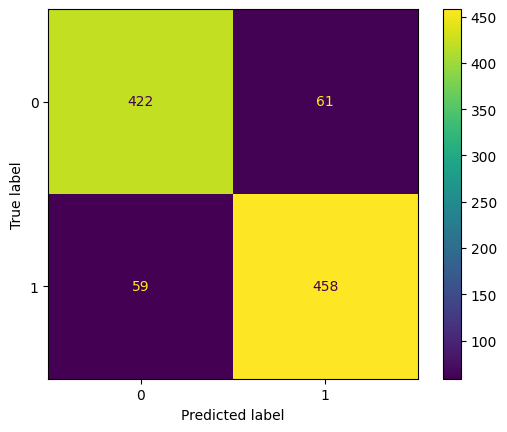

-----------------------------------------------------
DATASET: imdb_md
Accuracy score: 0.8754
Precision score: 0.8617546524876567


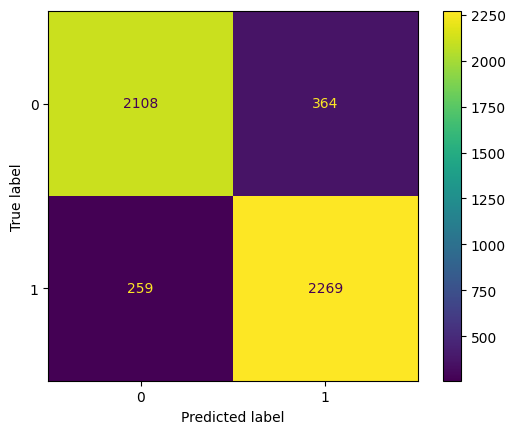

-----------------------------------------------------
DATASET: imdb_lg
Accuracy score: 0.8782105263157894
Precision score: 0.8624505126383109


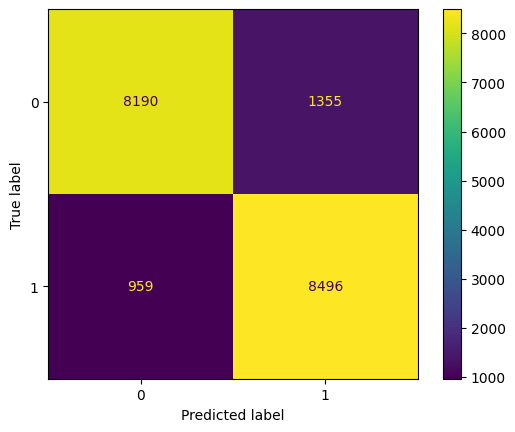

-----------------------------------------------------
DATASET: short_v1
Accuracy score: 0.7708333333333334
Precision score: 0.7624768946395564


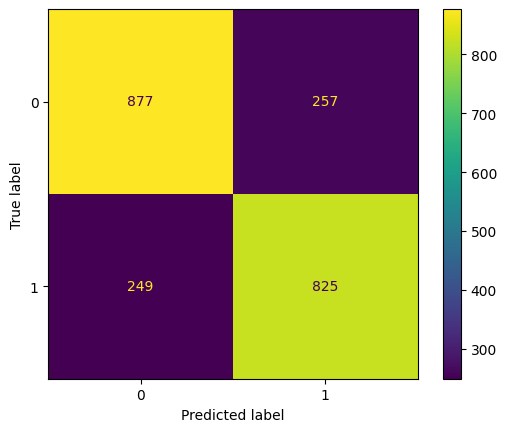

-----------------------------------------------------
DATASET: short_rotten
Accuracy score: 0.7366
Precision score: 0.8165041782729805


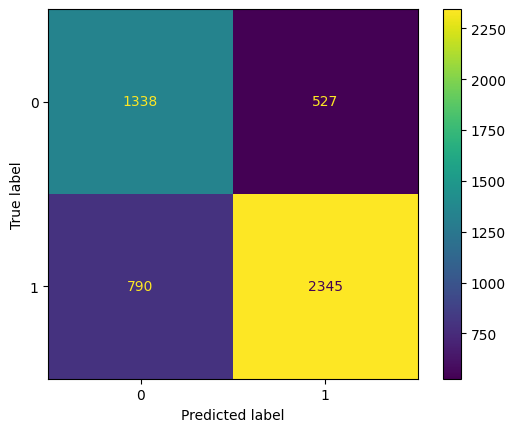

-----------------------------------------------------
DATASET: rotten_mix
Accuracy score: 0.7444
Precision score: 0.8263876880511845


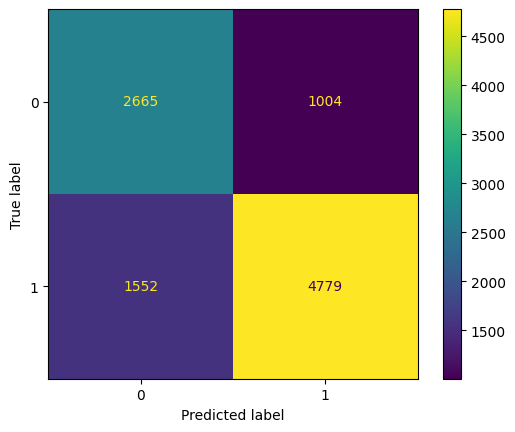

-----------------------------------------------------
DATASET: long (v2+imdb)
Accuracy score: 0.8221728732490605
Precision score: 0.7966154810404262


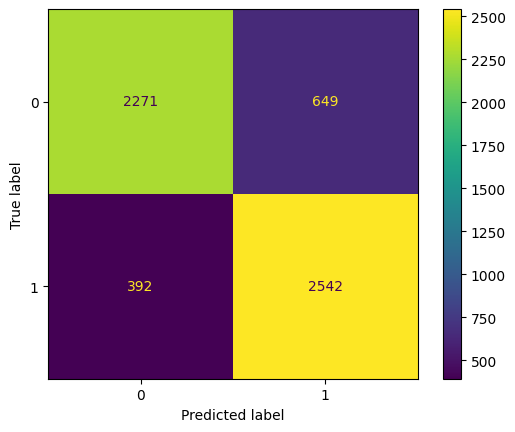

-----------------------------------------------------
DATASET: rest v1(more than 25 tokens)
Accuracy score: 0.7444698703279939
Precision score: 0.7371428571428571


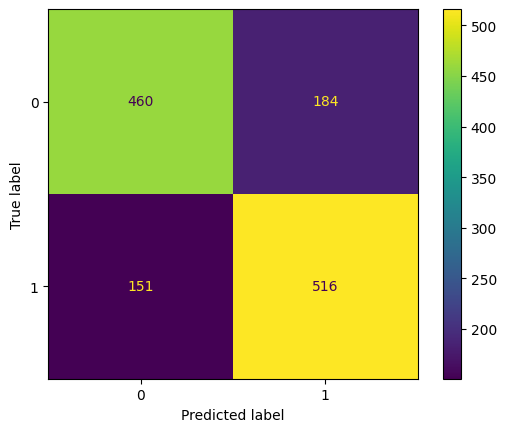

-----------------------------------------------------
DATASET: entire v2 test
Accuracy score: 0.86
Precision score: 0.835195530726257


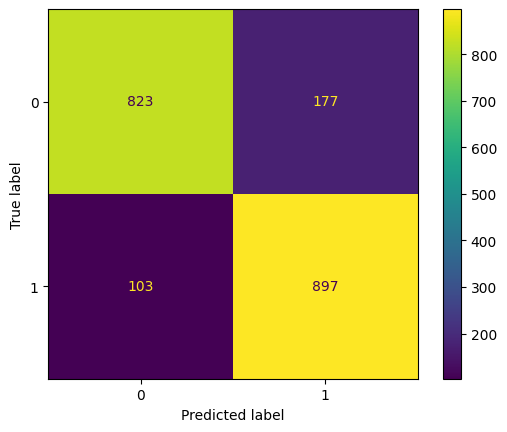

-----------------------------------------------------
DATASET: rotten_pos_only
Accuracy score: 0.751
Precision score: 1.0


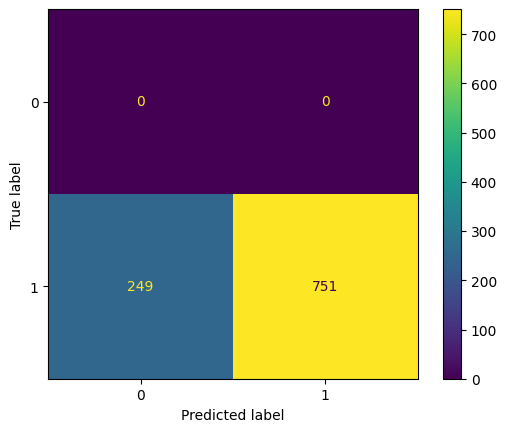

-----------------------------------------------------
DATASET: rotten_neg_only
Accuracy score: 0.721
Precision score: 0.0


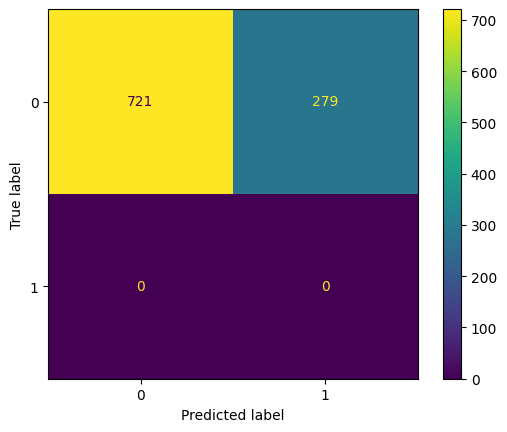

-----------------------------------------------------


In [36]:
results_dict = {}

for (X_test, y_test, name) in encoded_test_sets:
    acc, precision = test_loop(X_test, y_test, set_name=name, model=model)
    acc_key = f"{name}_acc"
    prec_key = f"{name}_prec"
    
    results_dict[acc_key] = acc
    results_dict[prec_key] = precision   

In [37]:
import json

def write_results(exp_path, results_dict):
    
    res_path = os.path.join(exp_path, 'results.json')
    json_data = json.dumps(results_dict, indent=1)
    
    if os.path.exists(res_path):
        print("Results file already exists for this experiment. Aborting")
        return None
    
    with open(res_path, 'w') as f:
        f.write(json_data)
        
write_results(exp_path=exp_path, results_dict=results_dict)